# Telecom Churn

## About Dataset

### About The Dataset

The selected data source is the open-source Cell2Cell dataset provided by the Teradata Center for Customer Relationship Management at Duke University.

This preprocessed Cell2Cell dataset has been balanced for process analysis, comprising 71,047 instances and 58 attributes. We can employ both traditional machine learning and deep learning algorithms to assess metrics such as accuracy, ROC, and AUC.

In the telecom industry, intense competition exists in satisfying customers. The churn prediction system's role extends beyond accurately predicting churners to understanding customer churn behavior.

Churn management in the telecom sector aims to retain customers for a company. Effective customer management involves anticipating when a customer may switch to another service provider, assessing customer profitability, and implementing a range of strategic and tactical retention strategies to minimize customer attrition.

In practical terms, we can categorize customers by profitability and concentrate retention efforts on the profitable segments. Additionally, we can assign a churn propensity score to the entire customer base, enabling us to prioritize retention initiatives based on both profitability and churn likelihood.

https://www.kaggle.com/datasets/jpacse/datasets-for-churn-telecom

## Spark and Other Imports

In [54]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, split, regexp_replace, udf, struct, lit,  trim, asc, desc, round, mean
from pyspark.sql.functions import isnan, when, count , isnull , col, substring
from pyspark.sql.functions import to_timestamp, to_date, unix_timestamp, date_format, hour   ### --> Date manipulation
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler, OneHotEncoder,StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, ClusteringEvaluator , MulticlassClassificationEvaluator

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import regex as re
import os


In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn import metrics

import keras
from keras import Sequential, regularizers
from tensorflow.keras.optimizers import SGD , RMSprop, Adam
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils
import xgboost as xgb

### Spark session

In [4]:
# Create SparkSession in local environment
spark = (
    SparkSession.builder.appName("Telecom_Churn")  # create a name
    .config("spark.executor.memory", "10g")  # Maximum amount of memory allowed
    .config("spark.executor.cores", "3")  # Maximum cpu threads allowed
    .config("spark.cores.max", "3")
    .config("spark.driver.memory", "10g")
    .config("spark.sql.broadcastTimeout", "9000")
    .getOrCreate()
)
# SparkConf().getAll()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/09/28 22:45:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Importing Dataset

#### Import the training dataset

In [5]:
df = spark.read.csv("cell2celltrain.csv", header="true", inferSchema=True)
df = df.na.drop()

In [6]:
df.describe().show()

23/09/28 22:45:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-----+------------------+-----------------+--------------------+---------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+--------------------+------------------+------------------+------------------+------------------+-----------+------------------+------------------+--------------------+-----------------+------------------+------------+------------------+-----------------+----------+-------+-------------+----------------+--------------------+--------------+-----------+------------+-------------+-------------------+-----------------------+----------------+-------------------+-------------------------+-----------------+--------------+-------------------------+-----------------+-----------------------+------------+--

#### Delete the rows with 'NA' values

In [7]:
for column in df.columns:
    if df.schema[column].dataType == pyspark.sql.types.StringType():
        df = df.filter(df[column] != "NA")

#### Check the description of Churn column


In [8]:
df.select("Churn").describe().show()

+-------+-----+
|summary|Churn|
+-------+-----+
|  count|49752|
|   mean| null|
| stddev| null|
|    min|   No|
|    max|  Yes|
+-------+-----+



## Data Manipulation

### `String` Column Handling

#### Type conversion of string columns into numerical

In [9]:
# Going through all columns required to be transfer into numerical values
columns_string = [
    column
    for column in df.columns
    if df.schema[column].dataType == pyspark.sql.types.StringType()
]
columns_string

['Churn',
 'MonthlyRevenue',
 'MonthlyMinutes',
 'TotalRecurringCharge',
 'DirectorAssistedCalls',
 'OverageMinutes',
 'RoamingCalls',
 'PercChangeMinutes',
 'PercChangeRevenues',
 'ServiceArea',
 'Handsets',
 'HandsetModels',
 'CurrentEquipmentDays',
 'AgeHH1',
 'AgeHH2',
 'ChildrenInHH',
 'HandsetRefurbished',
 'HandsetWebCapable',
 'TruckOwner',
 'RVOwner',
 'Homeownership',
 'BuysViaMailOrder',
 'RespondsToMailOffers',
 'OptOutMailings',
 'NonUSTravel',
 'OwnsComputer',
 'HasCreditCard',
 'NewCellphoneUser',
 'NotNewCellphoneUser',
 'OwnsMotorcycle',
 'HandsetPrice',
 'MadeCallToRetentionTeam',
 'CreditRating',
 'PrizmCode',
 'Occupation',
 'MaritalStatus']

In [10]:
# create the view of df under spark
df.createOrReplaceTempView("df")

In [11]:
# check the distribution of picked columns
spark.sql(
    "SELECT \
            Churn, \
            CAST (avg(MonthlyRevenue) as decimal(8,2)) as avg_MonthlyRevenue, \
            CAST (avg(MonthlyMinutes) as decimal(8,2)) as avg_MonthlyMinutes, \
            CAST (avg(CurrentEquipmentDays) as decimal(8,2)) as avg_CurrentEquipmentDays, \
            CAST (avg(TotalRecurringCharge) as decimal(8,2)) as avg_TotalRecurringCharge, \
            CAST (avg(OverageMinutes) as decimal(8,2)) as avg_OverageMinutes, \
            CAST (avg(RoamingCalls) as decimal(8,2)) as avg_RoamingCalls \
            FROM df GROUP BY Churn"
).show()

+-----+------------------+------------------+------------------------+------------------------+------------------+----------------+
|Churn|avg_MonthlyRevenue|avg_MonthlyMinutes|avg_CurrentEquipmentDays|avg_TotalRecurringCharge|avg_OverageMinutes|avg_RoamingCalls|
+-----+------------------+------------------+------------------------+------------------------+------------------+----------------+
|   No|             59.06|            541.81|                  363.64|                   47.72|             38.82|            1.16|
|  Yes|             57.87|            483.16|                  420.85|                   44.62|             42.08|            1.40|
+-----+------------------+------------------+------------------------+------------------------+------------------+----------------+



In [12]:
# Check the values of string columns
df.select([column for column in df.columns if column in columns_string]).show(3)

+-----+--------------+--------------+--------------------+---------------------+--------------+------------+-----------------+------------------+-----------+--------+-------------+--------------------+------+------+------------+------------------+-----------------+----------+-------+-------------+----------------+--------------------+--------------+-----------+------------+-------------+----------------+-------------------+--------------+------------+-----------------------+------------+---------+------------+-------------+
|Churn|MonthlyRevenue|MonthlyMinutes|TotalRecurringCharge|DirectorAssistedCalls|OverageMinutes|RoamingCalls|PercChangeMinutes|PercChangeRevenues|ServiceArea|Handsets|HandsetModels|CurrentEquipmentDays|AgeHH1|AgeHH2|ChildrenInHH|HandsetRefurbished|HandsetWebCapable|TruckOwner|RVOwner|Homeownership|BuysViaMailOrder|RespondsToMailOffers|OptOutMailings|NonUSTravel|OwnsComputer|HasCreditCard|NewCellphoneUser|NotNewCellphoneUser|OwnsMotorcycle|HandsetPrice|MadeCallToReten

#### Based on the values of the string columns, select the list of columns for StringIndexer

In [13]:
columns_for_indexer = [ "Churn","ChildrenInHH","HandsetRefurbished","HandsetWebCapable","TruckOwner",
                        "RVOwner","Homeownership","BuysViaMailOrder","RespondsToMailOffers","OptOutMailings",
                        "NonUSTravel","OwnsComputer","HasCreditCard","NewCellphoneUser","NotNewCellphoneUser",
                        "OwnsMotorcycle","MadeCallToRetentionTeam","MaritalStatus"
                      ]

In [14]:
# Loop the list and use StringIndexer encodes the string columns of labels(Yes or No) to columns of label indices(1 or 0)
for column in columns_for_indexer:
    indexer = StringIndexer(inputCol=column, outputCol=column + "Index")
    df = indexer.fit(df).transform(df)

In [15]:
df.show(3)

+----------+-----+--------------+--------------+--------------------+---------------------+--------------+------------+-----------------+------------------+------------+------------+---------------+-----------------+-------------+-------------+-------------+------------+--------------+-----------------+-------------------+-------------------+----------------+---------------+----------+----------+-----------+--------+-------------+--------------------+------+------+------------+------------------+-----------------+----------+-------+-------------+----------------+--------------------+--------------+-----------+------------+-------------+--------------+-----------------------+----------------+-------------------+-------------------------+-----------+--------------+-------------------------+------------+-----------------------+------------+---------+------------+-------------+----------+-----------------+-----------------------+----------------------+---------------+------------+---------

#### Drop the original string columns of labels

In [16]:
df = df.select([column for column in df.columns if column not in columns_for_indexer])

In [17]:
df.show(3)

+----------+--------------+--------------+--------------------+---------------------+--------------+------------+-----------------+------------------+------------+------------+---------------+-----------------+-------------+-------------+-------------+------------+--------------+-----------------+-------------------+-------------------+----------------+---------------+----------+----------+-----------+--------+-------------+--------------------+------+------+--------------+-----------------------+-------------------------+-----------+-------------------------+------------+------------+---------+------------+----------+-----------------+-----------------------+----------------------+---------------+------------+------------------+---------------------+-------------------------+-------------------+----------------+-----------------+------------------+---------------------+------------------------+-------------------+----------------------------+------------------+
|CustomerID|MonthlyReve

In [18]:
# Check the Churn column again to confirm the result
df.select("ChurnIndex").describe().show()

+-------+-------------------+
|summary|         ChurnIndex|
+-------+-------------------+
|  count|              49752|
|   mean|0.28632014793375143|
| stddev|0.45204538278095574|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



In [19]:
# Replace unknown values to 0 for HandsetPrice Column
df = df.replace(to_replace={"Unknown": "0"}, subset=["HandsetPrice"])

In [20]:
# Delete the rows with 'NA' values
for column in df.columns:
    if df.schema[column].dataType == pyspark.sql.types.StringType():
        df = df.filter(df[column] != "Unknown")

In [21]:
# Another Iteration for feature engineering
columns_string = [
    column
    for column in df.columns
    if df.schema[column].dataType == pyspark.sql.types.StringType()
]
columns_string

['MonthlyRevenue',
 'MonthlyMinutes',
 'TotalRecurringCharge',
 'DirectorAssistedCalls',
 'OverageMinutes',
 'RoamingCalls',
 'PercChangeMinutes',
 'PercChangeRevenues',
 'ServiceArea',
 'Handsets',
 'HandsetModels',
 'CurrentEquipmentDays',
 'AgeHH1',
 'AgeHH2',
 'HandsetPrice',
 'CreditRating',
 'PrizmCode',
 'Occupation']

In [22]:
# Mapping string values into integer based on its values
mapping_PrizmCode = {"Other": "0", "Suburban": "1", "Town": "2", "Rural": "3"}
df = df.replace(to_replace = mapping_PrizmCode, subset=["PrizmCode"])

### Find and cast columns to `Float`

#### Prepare the list of columns to be transformed into float

In [23]:
columns_to_float = [
    "MonthlyRevenue",
    "MonthlyMinutes",
    "TotalRecurringCharge",
    "DirectorAssistedCalls",
    "OverageMinutes",
    "RoamingCalls",
    "PercChangeMinutes",
    "PercChangeRevenues",
]

#### Transform ServiceArea and CreditRating columns only to keep the int value

In [24]:
df = df.withColumn("ServiceArea", df["ServiceArea"].substr(-3, 3))
df = df.withColumn("CreditRating", df["CreditRating"].substr(1, 1))

In [25]:
# Transform the type of columns to float
for column in columns_to_float:
    df = df.withColumn(column, df[column].cast("float"))

In [26]:
# Create a Pandas DataFrame for data visualization
df_pd = df.toPandas()

In [27]:
# Transform string values to numbers using mapping
temp = (
    df_pd.loc[:, ["Occupation", "MonthlyRevenue"]]
    .groupby("Occupation")
    .mean()
    .sort_values(["MonthlyRevenue"], ascending=[0])
)

mapping_Occupation = dict([temp.index[i], str(i)] for i in range(len(temp)))
print(mapping_Occupation)

df = df.replace(to_replace=mapping_Occupation, subset=["Occupation"])

{'Other': '0', 'Self': '1', 'Student': '2', 'Crafts': '3', 'Clerical': '4', 'Professional': '5', 'Homemaker': '6', 'Retired': '7'}


### Find and Cast columns to `integers`

#### Prepare the list of columns to be transformed into integer

In [28]:
columns_to_int = ["Handsets","HandsetModels","CurrentEquipmentDays","AgeHH1","AgeHH2",
                  "HandsetPrice","ServiceArea","CreditRating","PrizmCode","Occupation","ChurnIndex","ChildrenInHHIndex",
                  "HandsetRefurbishedIndex","HandsetWebCapableIndex","TruckOwnerIndex","RVOwnerIndex","HomeownershipIndex",
                  "BuysViaMailOrderIndex","RespondsToMailOffersIndex","OptOutMailingsIndex","NonUSTravelIndex","OwnsComputerIndex",
                  "HasCreditCardIndex","NewCellphoneUserIndex","NotNewCellphoneUserIndex","OwnsMotorcycleIndex",
                  "MadeCallToRetentionTeamIndex","MaritalStatusIndex",
                  ]

#### Transform the type of columns to integer

In [29]:
for column in columns_to_int:
    df = df.withColumn(column, df[column].cast("int"))

## Data Visulization

From a business perspective, we can select below columns to visulaize and understand the data

-	Customer demography: Age, Tenure, Gender, Location, Zip code, etc.
-	Bill and payment: Monthly fee, Billing amount, Count of overdue payment, payment method, Billing type, etc.
-	Network/TV/Phone usage records: Network use frequency, network flow, usage time and period, internet average speed, In-net call duration, Call type, etc.
-	Customer care/service: Service call number, service type, service duration, account change count
-	Competitors information: Offer detail under similar plan, etc


In [30]:
# Create a new Pandas DataFrame for data visualization
df_pd = df.toPandas()

In [31]:
# Define Catplot function and Barplot function
def cat_plot(feature, cut=12):
    temp = df_pd.loc[:, [feature, "ChurnIndex"]]
    temp[feature + "_binned"] = pd.qcut(temp[feature], cut, duplicates="drop")
    ax = sns.catplot(
        x="ChurnIndex",
        y=feature + "_binned",
        data=temp,
        kind="bar",
        height=5,
        aspect=2.7,
    )


def bar_plot(feature, cut=False, logscale=False, drop_zero=False):
    if drop_zero:
        temp = df_pd[df_pd[feature] != 0].loc[:, [feature, "ChurnIndex"]]
    else:
        temp = df_pd.loc[:, [feature, "ChurnIndex"]]

    if cut > 0:
        temp[feature + "_binned"] = pd.qcut(temp[feature], cut, duplicates="drop")
        ax = sns.barplot(x=feature + "_binned", y="ChurnIndex", data=temp)
    else:
        ax = sns.barplot(x=feature, y="ChurnIndex", data=temp)

    if logscale:
        ax.set_yscale("log")

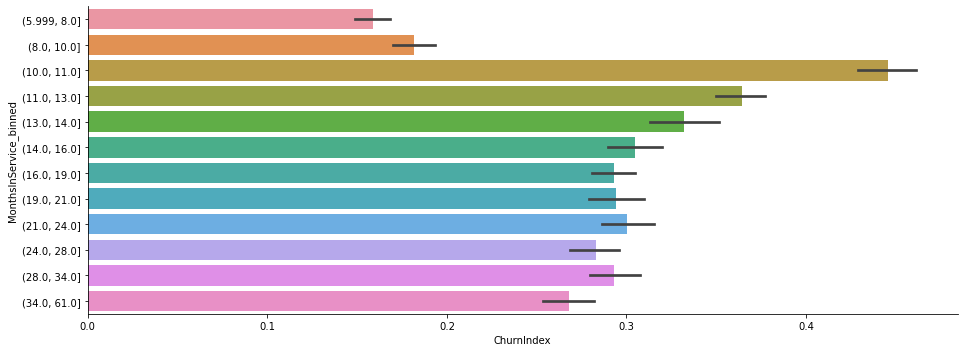

In [32]:
# Use defined Catplot function plot the distribution of MonthsInService
cat_plot("MonthsInService", cut=12)

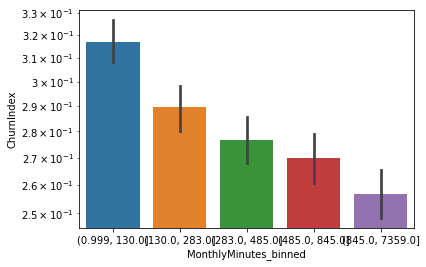

In [33]:
# Use defined Barplot function plot the distribution of MonthlyMinutes
bar_plot("MonthlyMinutes", cut=5, logscale=True, drop_zero=True)


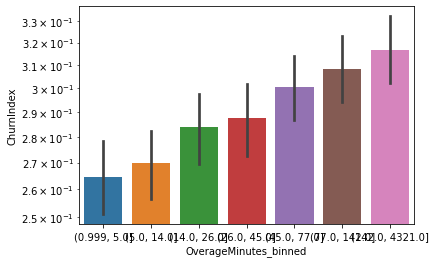

In [34]:
# Use defined Barplot function plot the distribution of OverageMinutes
bar_plot("OverageMinutes", cut=7, logscale=True, drop_zero=True)

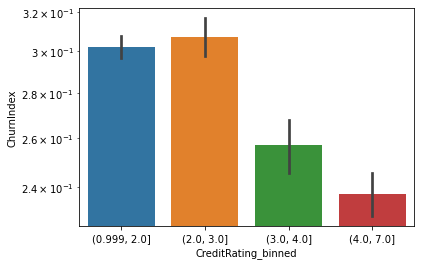

In [35]:
# Use defined Barplot function plot the distribution of CreditRating
bar_plot("CreditRating", cut=5, logscale=True)

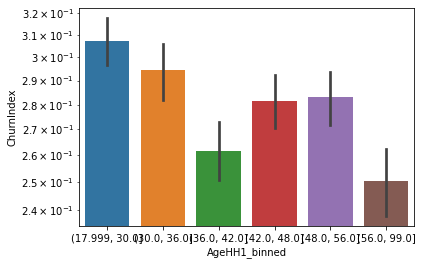

In [36]:
# Use defined Barplot function plot the distribution of AgeHH1
bar_plot("AgeHH1", cut=6, logscale=True, drop_zero=True)

<AxesSubplot:xlabel='MadeCallToRetentionTeam', ylabel='ChurnIndex'>

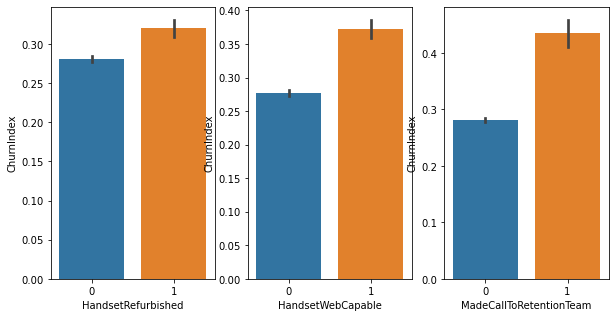

In [37]:
# Subplots the distribution of HandsetRefurbished, HandsetWebCapable and MadeCallToRetentionTeam into one graph
feature = [
    "HandsetRefurbishedIndex",
    "HandsetWebCapableIndex",
    "MadeCallToRetentionTeamIndex",
    "ChurnIndex",
]
temp = df_pd.loc[:, feature]
temp.columns = [
    "HandsetRefurbished",
    "HandsetWebCapable",
    "MadeCallToRetentionTeam",
    "ChurnIndex",
]

fig, axs = plt.subplots(figsize=(10, 5), ncols=3)
sns.barplot(x="HandsetRefurbished", y="ChurnIndex", data=temp, ax=axs[0])
sns.barplot(x="HandsetWebCapable", y="ChurnIndex", data=temp, ax=axs[1])
sns.barplot(x="MadeCallToRetentionTeam", y="ChurnIndex", data=temp, ax=axs[2])


#### Function to Plot ROC curve

In [61]:
# Define plot roc curve function
def plot_roc_curve(model, train, test):
    predictions = model.transform(test)
    predictions_train = model.transform(train)

    results = predictions.select(["probability", "label"])
    results_train = predictions_train.select(["probability", "label"])

    ## prepare score-label set
    results_collect = results.collect()
    results_list = [(float(i[0][0]), 1.0 - float(i[1])) for i in results_collect]

    results_collect_train = results_train.collect()
    results_list_train = [
        (float(i[0][0]), 1.0 - float(i[1])) for i in results_collect_train
    ]

    fpr = dict()
    fpr_train = dict()
    tpr = dict()
    tpr_train = dict()
    roc_auc = dict()
    roc_auc_train = dict()

    y_test = [i[1] for i in results_list]
    y_score = [i[0] for i in results_list]

    y_train = [i[1] for i in results_list_train]
    y_score_train = [i[0] for i in results_list_train]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve on testing set (area = %0.2f)" % roc_auc)
    plt.plot(
        fpr_train,
        tpr_train,
        label="ROC curve on training set (area = %0.2f)" % roc_auc_train,
    )
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()


## Data Preprocessing

#### Create column list for VectorAssembler and trandform it into single vevtor column

In [38]:
inputcols = [
    column for column in df.columns if column not in ["CustomerID", "ChurnIndex"]
]

In [39]:
vectorAssembler = VectorAssembler(inputCols=inputcols, outputCol="features")
features_vectorized = vectorAssembler.transform(df)
features_vectorized = features_vectorized.withColumnRenamed("ChurnIndex", "label")

#### StandardScaler

In [40]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# # Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(features_vectorized)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(features_vectorized)
scaledData.show()

+----------+--------------+--------------+--------------------+---------------------+--------------+------------+-----------------+------------------+------------+------------+---------------+-----------------+-------------+-------------+-------------+------------+--------------+-----------------+-------------------+-------------------+----------------+---------------+----------+----------+-----------+--------+-------------+--------------------+------+------+--------------+-----------------------+-------------------------+-----------+-------------------------+------------+------------+---------+----------+-----+-----------------+-----------------------+----------------------+---------------+------------+------------------+---------------------+-------------------------+-------------------+----------------+-----------------+------------------+---------------------+------------------------+-------------------+----------------------------+------------------+--------------------+----------

In [41]:
# Check the distribution of label
scaledData.select("label").groupBy("label").count().collect()

[Row(label=1, count=14245), Row(label=0, count=35507)]

Since the data set is highly skewed (ie we have much more Negative training samples than Positive training samples)

We can use down-samplings (which means we just randomly filter out some of the majority cases.)

In [42]:
# Down-sampling
scaledData_ds, _ = scaledData.filter(scaledData["label"] == 0.0).randomSplit([0.4, 0.6])
scaledData_ds = scaledData.filter(scaledData["label"] == 1.0).union(scaledData_ds)
scaledData_ds.select("label").groupBy("label").count().collect()

[Row(label=1, count=14245), Row(label=0, count=14149)]

In [43]:
# Split dataset into train and test set
train, test = scaledData_ds.randomSplit([0.8, 0.2])

## Random Forest Classifier Model

In [44]:
# Validation for hyper-parameter tuning.
# Randomly splits the input dataset into train and validation sets,
# and uses evaluation metric on the validation set to select the best model.
rf = RandomForestClassifier(
    featuresCol="features", labelCol="label", predictionCol="prediction", maxBins=16
)

# Use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using the evaluator.
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.maxDepth, [8, 10, 12])
    .addGrid(rf.minInstancesPerNode, [1, 3, 5, 10])
    .addGrid(rf.numTrees, [10, 20])
    .build()
)

# In this case the estimator is BinaryClassificationEvaluator
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(),
    trainRatio=0.8,
)  # 80% of the data will be used for training, 20% for validation.

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train)


23/09/28 22:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1007.0 KiB
23/09/28 22:48:36 WARN DAGScheduler: Broadcasting large task binary with size 1281.5 KiB


23/09/28 22:48:38 WARN DAGScheduler: Broadcasting large task binary with size 1156.7 KiB
23/09/28 22:48:47 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
23/09/28 22:48:48 WARN DAGScheduler: Broadcasting large task binary with size 1283.3 KiB


23/09/28 22:48:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB


23/09/28 22:49:05 WARN DAGScheduler: Broadcasting large task binary with size 1004.9 KiB
23/09/28 22:49:06 WARN DAGScheduler: Broadcasting large task binary with size 1271.8 KiB
23/09/28 22:49:08 WARN DAGScheduler: Broadcasting large task binary with size 1074.3 KiB
23/09/28 22:49:16 WARN DAGScheduler: Broadcasting large task binary with size 1241.4 KiB
23/09/28 22:49:18 WARN DAGScheduler: Broadcasting large task binary with size 1030.6 KiB
23/09/28 22:49:23 WARN DAGScheduler: Broadcasting large task binary with size 1177.9 KiB
23/09/28 22:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1484.4 KiB
23/09/28 22:49:26 WARN DAGScheduler: Broadcasting large task binary with size 1273.5 KiB


23/09/28 22:49:31 WARN DAGScheduler: Broadcasting large task binary with size 1007.0 KiB
23/09/28 22:49:32 WARN DAGScheduler: Broadcasting large task binary with size 1281.5 KiB


23/09/28 22:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1696.4 KiB


23/09/28 22:49:37 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/09/28 22:49:39 WARN DAGScheduler: Broadcasting large task binary with size 1870.5 KiB


23/09/28 22:49:46 WARN DAGScheduler: Broadcasting large task binary with size 1171.1 KiB
23/09/28 22:49:47 WARN DAGScheduler: Broadcasting large task binary with size 1463.8 KiB


23/09/28 22:49:50 WARN DAGScheduler: Broadcasting large task binary with size 1175.9 KiB


23/09/28 22:49:55 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB


23/09/28 22:49:57 WARN DAGScheduler: Broadcasting large task binary with size 1283.3 KiB


23/09/28 22:49:59 WARN DAGScheduler: Broadcasting large task binary with size 1696.0 KiB


23/09/28 22:50:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/09/28 22:50:05 WARN DAGScheduler: Broadcasting large task binary with size 1675.8 KiB


23/09/28 22:50:18 WARN DAGScheduler: Broadcasting large task binary with size 1150.5 KiB


23/09/28 22:50:19 WARN DAGScheduler: Broadcasting large task binary with size 1427.9 KiB


23/09/28 22:50:22 WARN DAGScheduler: Broadcasting large task binary with size 1120.4 KiB


23/09/28 22:50:30 WARN DAGScheduler: Broadcasting large task binary with size 1004.9 KiB


23/09/28 22:50:31 WARN DAGScheduler: Broadcasting large task binary with size 1271.8 KiB


23/09/28 22:50:34 WARN DAGScheduler: Broadcasting large task binary with size 1664.0 KiB


23/09/28 22:50:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/09/28 22:50:39 WARN DAGScheduler: Broadcasting large task binary with size 1565.9 KiB
23/09/28 22:50:44 WARN DAGScheduler: Broadcasting large task binary with size 1115.6 KiB


23/09/28 22:50:46 WARN DAGScheduler: Broadcasting large task binary with size 1350.3 KiB
23/09/28 22:50:47 WARN DAGScheduler: Broadcasting large task binary with size 1029.8 KiB
23/09/28 22:50:51 WARN DAGScheduler: Broadcasting large task binary with size 1241.4 KiB


23/09/28 22:50:53 WARN DAGScheduler: Broadcasting large task binary with size 1589.0 KiB
23/09/28 22:50:54 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/09/28 22:50:58 WARN DAGScheduler: Broadcasting large task binary with size 1407.4 KiB


23/09/28 22:51:05 WARN DAGScheduler: Broadcasting large task binary with size 1177.9 KiB
23/09/28 22:51:06 WARN DAGScheduler: Broadcasting large task binary with size 1484.4 KiB
23/09/28 22:51:07 WARN DAGScheduler: Broadcasting large task binary with size 1903.8 KiB


23/09/28 22:51:08 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/09/28 22:51:11 WARN DAGScheduler: Broadcasting large task binary with size 1919.7 KiB
23/09/28 22:51:15 WARN DAGScheduler: Broadcasting large task binary with size 1007.0 KiB
23/09/28 22:51:15 WARN DAGScheduler: Broadcasting large task binary with size 1281.5 KiB
23/09/28 22:51:16 WARN DAGScheduler: Broadcasting large task binary with size 1696.4 KiB


23/09/28 22:51:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/09/28 22:51:19 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/09/28 22:51:21 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


23/09/28 22:51:23 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/09/28 22:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1171.1 KiB


23/09/28 22:51:30 WARN DAGScheduler: Broadcasting large task binary with size 1463.8 KiB
23/09/28 22:51:31 WARN DAGScheduler: Broadcasting large task binary with size 1854.4 KiB


23/09/28 22:51:32 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/09/28 22:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1642.9 KiB


23/09/28 22:51:41 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
23/09/28 22:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1283.3 KiB
23/09/28 22:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1696.0 KiB
23/09/28 22:51:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/09/28 22:51:44 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/09/28 22:51:46 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


23/09/28 22:51:48 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/09/28 22:51:51 WARN DAGScheduler: Broadcasting large task binary with size 1150.5 KiB
23/09/28 22:51:51 WARN DAGScheduler: Broadcasting large task binary with size 1427.9 KiB
23/09/28 22:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1799.3 KiB


23/09/28 22:51:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/09/28 22:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1490.7 KiB
23/09/28 22:52:03 WARN DAGScheduler: Broadcasting large task binary with size 1004.9 KiB
23/09/28 22:52:03 WARN DAGScheduler: Broadcasting large task binary with size 1271.8 KiB
23/09/28 22:52:04 WARN DAGScheduler: Broadcasting large task binary with size 1664.0 KiB
23/09/28 22:52:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/09/28 22:52:06 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/09/28 22:52:07 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/09/28 22:52:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/09/28 22:52:13 WARN DAGScheduler: Broadcasting large task binary with size 1115.6 KiB
23/09/28 22:52:14 WARN DAGScheduler: Broadcasting large task binary with size 1350.3 KiB
23/09/28 22:52:15 WARN DAGScheduler: Broadcasting large task binary with size 1631.8 KiB


23/09/28 22:52:16 WARN DAGScheduler: Broadcasting large task binary with size 1955.7 KiB
23/09/28 22:52:17 WARN DAGScheduler: Broadcasting large task binary with size 1259.7 KiB


23/09/28 22:52:23 WARN DAGScheduler: Broadcasting large task binary with size 1241.4 KiB


23/09/28 22:52:26 WARN DAGScheduler: Broadcasting large task binary with size 1589.0 KiB


23/09/28 22:52:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/09/28 22:52:31 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/09/28 22:52:33 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


23/09/28 22:52:37 WARN DAGScheduler: Broadcasting large task binary with size 1876.8 KiB


23/09/28 22:53:15 WARN DAGScheduler: Broadcasting large task binary with size 1230.0 KiB
23/09/28 22:53:15 WARN DAGScheduler: Broadcasting large task binary with size 1645.0 KiB
23/09/28 22:53:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


In [45]:
predictions = model.transform(scaledData)

## Gradient Boosted Trees Classifier

In [59]:
# Validation for hyper-parameter tuning.
# Randomly splits the input dataset into train and validation sets,
# and uses evaluation metric on the validation set to select the best model.
gbt = GBTClassifier(
    featuresCol="features", labelCol="label", predictionCol="prediction"
)

# Use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using the evaluator.
paramGrid = (
    ParamGridBuilder()
    .addGrid(gbt.maxDepth, [8, 10])
    .addGrid(gbt.minInstancesPerNode, [5, 20, 50])
    .addGrid(gbt.maxIter, [10, 20])
    .build()
)

# In this case the estimator is BinaryClassificationEvaluator
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(),
    trainRatio=0.8,
)  # 80% of the data will be used for training, 20% for validation.

# Run TrainValidationSplit, and choose the best set of parameters.
model_gbt = tvs.fit(train)

# Make predictions on test data. model is the model with combination of parameters that performed best.
model_gbt.transform(test).select("features", "label", "prediction").show(10)


23/09/28 23:10:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/09/28 23:10:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


23/09/28 23:10:39 WARN DAGScheduler: Broadcasting large task binary with size 1002.1 KiB
23/09/28 23:10:39 WARN DAGScheduler: Broadcasting large task binary with size 1005.9 KiB
23/09/28 23:10:39 WARN DAGScheduler: Broadcasting large task binary with size 1011.0 KiB
23/09/28 23:10:39 WARN DAGScheduler: Broadcasting large task binary with size 1017.3 KiB
23/09/28 23:10:40 WARN DAGScheduler: Broadcasting large task binary with size 1014.7 KiB
23/09/28 23:10:40 WARN DAGScheduler: Broadcasting large task binary with size 1015.2 KiB
23/09/28 23:10:40 WARN DAGScheduler: Broadcasting large task binary with size 1015.7 KiB
23/09/28 23:10:41 WARN DAGScheduler: Broadcasting large task binary with size 1016.9 KiB
23/09/28 23:10:41 WARN DAGScheduler: Broadcasting large task binary with size 1019.1 KiB
23/09/28 23:10:41 WARN DAGScheduler: Broadcasting large task binary with size 1023.4 KiB
23/09/28 23:10:41 WARN DAGScheduler: Broadcasting large task binary with size 1031.7 KiB
23/09/28 23:10:42 WAR

23/09/28 23:12:10 WARN DAGScheduler: Broadcasting large task binary with size 1000.4 KiB
23/09/28 23:12:10 WARN DAGScheduler: Broadcasting large task binary with size 1003.3 KiB
23/09/28 23:12:10 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB
23/09/28 23:12:11 WARN DAGScheduler: Broadcasting large task binary with size 1004.5 KiB
23/09/28 23:12:11 WARN DAGScheduler: Broadcasting large task binary with size 1005.0 KiB
23/09/28 23:12:11 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
23/09/28 23:12:12 WARN DAGScheduler: Broadcasting large task binary with size 1008.4 KiB
23/09/28 23:12:12 WARN DAGScheduler: Broadcasting large task binary with size 1010.9 KiB
23/09/28 23:12:12 WARN DAGScheduler: Broadcasting large task binary with size 1015.2 KiB
23/09/28 23:12:12 WARN DAGScheduler: Broadcasting large task binary with size 1021.5 KiB
23/09/28 23:12:13 WARN DAGScheduler: Broadcasting large task binary with size 1012.8 KiB


23/09/28 23:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1012.5 KiB
23/09/28 23:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1001.9 KiB
23/09/28 23:13:36 WARN DAGScheduler: Broadcasting large task binary with size 1002.4 KiB
23/09/28 23:13:36 WARN DAGScheduler: Broadcasting large task binary with size 1003.0 KiB
23/09/28 23:13:36 WARN DAGScheduler: Broadcasting large task binary with size 1004.1 KiB
23/09/28 23:13:36 WARN DAGScheduler: Broadcasting large task binary with size 1006.1 KiB
23/09/28 23:13:36 WARN DAGScheduler: Broadcasting large task binary with size 1009.5 KiB
23/09/28 23:13:37 WARN DAGScheduler: Broadcasting large task binary with size 1014.8 KiB
23/09/28 23:13:37 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
23/09/28 23:13:37 WARN DAGScheduler: Broadcasting large task binary with size 1029.7 KiB
23/09/28 23:13:37 WARN DAGScheduler: Broadcasting large task binary with size 1038.4 KiB
23/09/28 23:13:38 WAR

23/09/28 23:13:44 WARN DAGScheduler: Broadcasting large task binary with size 1134.7 KiB
23/09/28 23:13:45 WARN DAGScheduler: Broadcasting large task binary with size 1135.2 KiB
23/09/28 23:13:45 WARN DAGScheduler: Broadcasting large task binary with size 1135.8 KiB
23/09/28 23:13:45 WARN DAGScheduler: Broadcasting large task binary with size 1136.9 KiB
23/09/28 23:13:45 WARN DAGScheduler: Broadcasting large task binary with size 1139.2 KiB
23/09/28 23:13:46 WARN DAGScheduler: Broadcasting large task binary with size 1142.9 KiB
23/09/28 23:13:46 WARN DAGScheduler: Broadcasting large task binary with size 1149.6 KiB
23/09/28 23:13:46 WARN DAGScheduler: Broadcasting large task binary with size 1160.0 KiB
23/09/28 23:13:47 WARN DAGScheduler: Broadcasting large task binary with size 1174.0 KiB
23/09/28 23:13:47 WARN DAGScheduler: Broadcasting large task binary with size 1192.7 KiB
23/09/28 23:13:48 WARN DAGScheduler: Broadcasting large task binary with size 1176.6 KiB
23/09/28 23:14:04 WAR

23/09/28 23:15:04 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB


23/09/28 23:15:31 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB
23/09/28 23:15:33 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB
23/09/28 23:15:34 WARN DAGScheduler: Broadcasting large task binary with size 1006.6 KiB
23/09/28 23:15:34 WARN DAGScheduler: Broadcasting large task binary with size 1006.0 KiB
23/09/28 23:15:34 WARN DAGScheduler: Broadcasting large task binary with size 1006.5 KiB
23/09/28 23:15:34 WARN DAGScheduler: Broadcasting large task binary with size 1007.1 KiB
23/09/28 23:15:35 WARN DAGScheduler: Broadcasting large task binary with size 1008.2 KiB
23/09/28 23:15:35 WARN DAGScheduler: Broadcasting large task binary with size 1010.0 KiB
23/09/28 23:15:35 WARN DAGScheduler: Broadcasting large task binary with size 1012.8 KiB
23/09/28 23:15:35 WARN DAGScheduler: Broadcasting large task binary with size 1017.5 KiB
23/09/28 23:15:35 WARN DAGScheduler: Broadcasting large task binary with size 1024.7 KiB
23/09/28 23:15:36 WAR

23/09/28 23:15:41 WARN DAGScheduler: Broadcasting large task binary with size 1080.1 KiB
23/09/28 23:15:41 WARN DAGScheduler: Broadcasting large task binary with size 1080.7 KiB
23/09/28 23:15:41 WARN DAGScheduler: Broadcasting large task binary with size 1081.8 KiB
23/09/28 23:15:41 WARN DAGScheduler: Broadcasting large task binary with size 1083.5 KiB
23/09/28 23:15:42 WARN DAGScheduler: Broadcasting large task binary with size 1086.4 KiB
23/09/28 23:15:42 WARN DAGScheduler: Broadcasting large task binary with size 1091.1 KiB
23/09/28 23:15:42 WARN DAGScheduler: Broadcasting large task binary with size 1098.5 KiB
23/09/28 23:15:43 WARN DAGScheduler: Broadcasting large task binary with size 1109.1 KiB
23/09/28 23:15:43 WARN DAGScheduler: Broadcasting large task binary with size 1123.4 KiB
23/09/28 23:15:44 WARN DAGScheduler: Broadcasting large task binary with size 1115.0 KiB
23/09/28 23:15:44 WARN DAGScheduler: Broadcasting large task binary with size 1115.4 KiB
23/09/28 23:15:44 WAR

23/09/28 23:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1001.7 KiB
23/09/28 23:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1006.5 KiB
23/09/28 23:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1001.7 KiB
23/09/28 23:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1002.2 KiB
23/09/28 23:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1002.5 KiB
23/09/28 23:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1003.1 KiB
23/09/28 23:17:10 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB
23/09/28 23:17:10 WARN DAGScheduler: Broadcasting large task binary with size 1005.4 KiB
23/09/28 23:17:10 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB
23/09/28 23:17:10 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB
23/09/28 23:17:11 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB
23/09/28 23:17:11 WAR

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(56,[0,1,2,4,6,7,...|    1|       1.0|
|(56,[0,1,2,6,8,9,...|    1|       0.0|
|(56,[0,1,2,6,7,8,...|    1|       0.0|
|(56,[0,1,2,3,4,6,...|    1|       0.0|
|[90.9000015258789...|    1|       1.0|
|[117.120002746582...|    1|       0.0|
|[77.0400009155273...|    1|       0.0|
|(56,[0,1,2,3,6,7,...|    1|       1.0|
|(56,[0,1,2,6,7,8,...|    1|       0.0|
|[79.8799972534179...|    1|       0.0|
+--------------------+-----+----------+
only showing top 10 rows



In [87]:
predictions_gbt = model_gbt.transform(scaledData)

## Evaluation and comparision

#### Making Evaluators

In [55]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

In [86]:
auroc = binary_evaluator.evaluate(predictions)
acc = acc_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
rc = recall_evaluator.evaluate(predictions)
f1 = f1_evaluator.evaluate(predictions)

23/09/28 23:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1240.5 KiB


23/09/28 23:31:26 WARN DAGScheduler: Broadcasting large task binary with size 1252.0 KiB


23/09/28 23:31:35 WARN DAGScheduler: Broadcasting large task binary with size 1252.0 KiB


23/09/28 23:31:39 WARN DAGScheduler: Broadcasting large task binary with size 1252.0 KiB


23/09/28 23:31:43 WARN DAGScheduler: Broadcasting large task binary with size 1252.0 KiB


In [88]:
auroc_gbt = binary_evaluator.evaluate(predictions_gbt)
acc_gbt = acc_evaluator.evaluate(predictions_gbt)
precision_gbt = precision_evaluator.evaluate(predictions_gbt)
rc_gbt = recall_evaluator.evaluate(predictions_gbt)
f1_gbt = f1_evaluator.evaluate(predictions_gbt)

#### Comparing both models

In [89]:
metrics = spark.createDataFrame([ ("Random Forest Classifier",acc, precision,rc,f1,auroc) ,
                                  ("Gradient Boost Classifier",acc_gbt, precision_gbt, rc_gbt, f1_gbt, auroc_gbt) 
                                ],

                                ["Model Name","Accuracy", "Precision","Recall","F1","AUROC"]
                              )
metrics.show()

+--------------------+------------------+------------------+------------------+------------------+------------------+
|          Model Name|          Accuracy|         Precision|            Recall|                F1|             AUROC|
+--------------------+------------------+------------------+------------------+------------------+------------------+
|Random Forest Cla...|0.6283365492844509|0.7280032837934737|0.6283365492844509|0.6459137503770116| 0.732022223570369|
|Gradient Boost Cl...|0.6489990352146647|0.7250564114462834|0.6489990352146647|0.6657164401168725|0.7291922366555538|
+--------------------+------------------+------------------+------------------+------------------+------------------+



## Segmenting Customers using KMeans

In this section, we will employ the KMeans algorithm to construct a Customer Segmentation model. Subsequently, we will analyze the distinctive characteristics of each cluster.

Customer segmentation involves categorizing customers into groups based on shared characteristics pertinent to marketing, including factors such as age, tenure, service usage, and expenditure.

By leveraging the insights gleaned from customer segmentation, the telecommunications company can fine-tune their marketing strategies for each distinct cluster. This approach allows for a more precise alignment with customer preferences, resulting in tailored marketing materials that resonate effectively.

In [91]:
# Trains a k-means model
kmeans = KMeans(featuresCol="scaledFeatures", k=4, initSteps=2, tol=0.0001, maxIter=20)
model_km = kmeans.fit(scaledData)

In [92]:
predictions_km = model.transform(scaledData)


In [99]:
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions_km)
print("Silhouette with squared euclidean distance = " + str(silhouette))

23/09/28 23:43:30 WARN DAGScheduler: Broadcasting large task binary with size 1245.7 KiB


23/09/28 23:43:39 WARN DAGScheduler: Broadcasting large task binary with size 1188.9 KiB


Silhouette with squared euclidean distance = 0.09571853560347696


In [100]:
# Create a Pandas DataFrame for data visualization
cluster = predictions_km.toPandas()

23/09/28 23:43:51 WARN DAGScheduler: Broadcasting large task binary with size 1200.0 KiB


In [107]:
importance = model.bestModel.featureImportances
features_list = inputcols

In [106]:
feature_importance = pd.DataFrame(
    data={"features_list": features_list, "importance": importance}
)

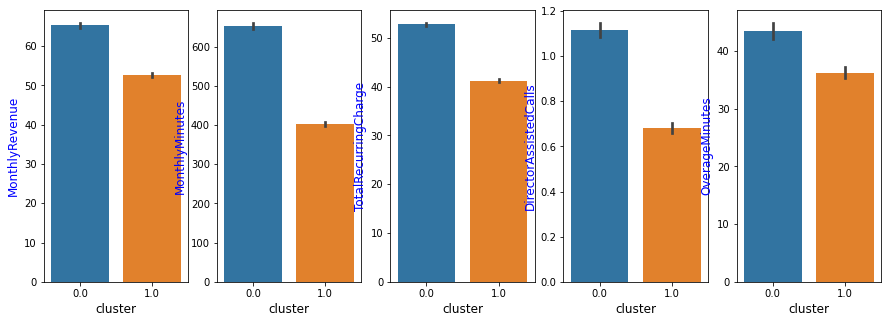

In [104]:
# Compare the different distributions of each cluster
temp_list = list(feature_importance.iloc[:5, 0])
temp_list.append("prediction")
temp = cluster.loc[:, temp_list]

fig, axs = plt.subplots(figsize=(15, 5), ncols=len(temp_list) - 1)

for i in range(len(temp_list) - 1):
    ax = sns.barplot(x="prediction", y=temp_list[i], data=temp, ax=axs[i])
    ax.set_xlabel("cluster", fontsize=12)
    ax.set_ylabel(temp_list[i], fontsize=12, color="blue")


## Conclusions

1. a
2. b